In [2]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import sklearn

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, precision_recall_fscore_support, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder



# Preprocessing

In [50]:
hfcr = pd.read_csv('heart_failure_clinical_records_dataset.csv')
hfcr.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [51]:
hfcr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


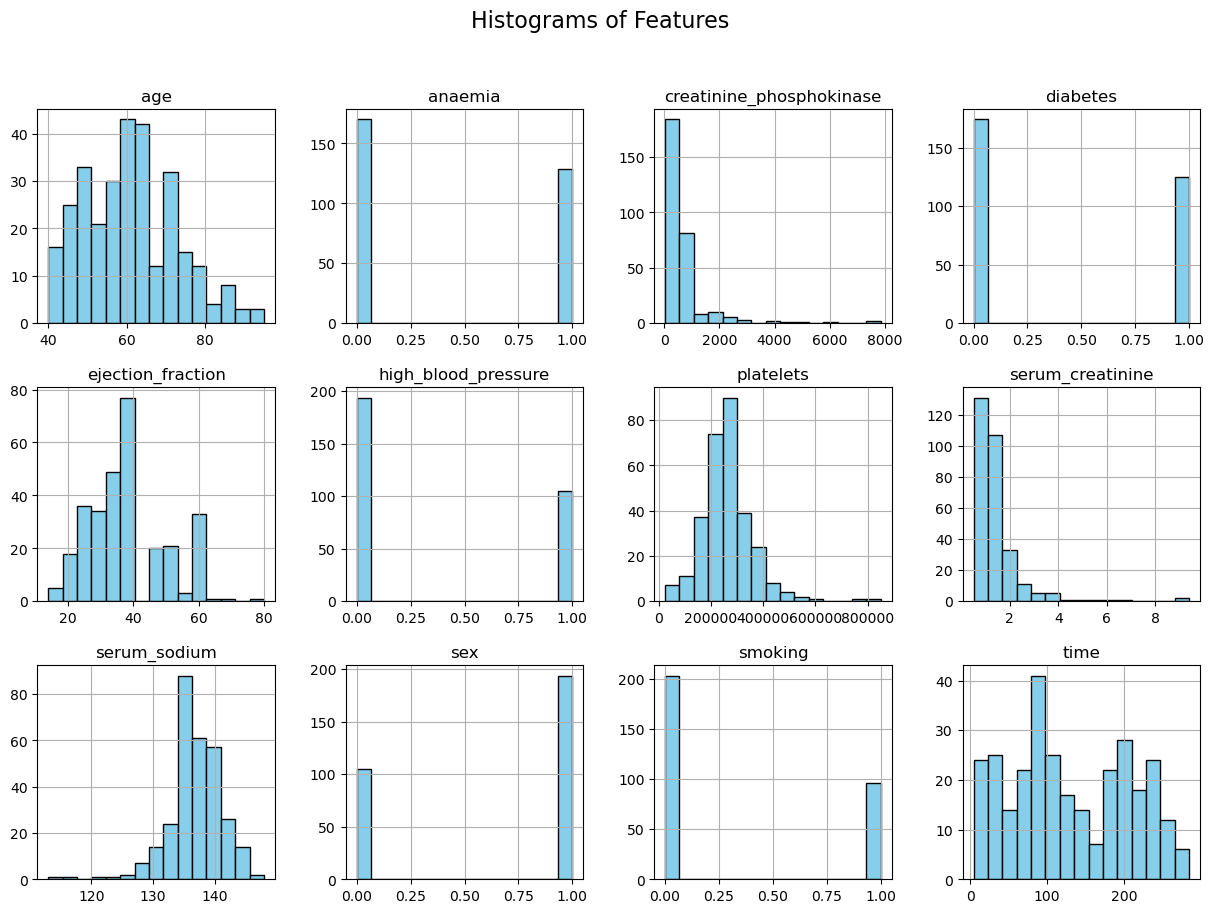

In [52]:
hfcr.iloc[:, :-1].hist(bins=15, figsize=(15, 10), layout=(3, 4), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Features', fontsize=16)
plt.show()



In [53]:
binary_features = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"]
continuous_features_standardize = ["age", "ejection_fraction", "serum_sodium", "time"]
continuous_features_normalize = ["creatinine_phosphokinase", "platelets", "serum_creatinine"]

standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

binary_data = hfcr[binary_features]

# Standardize normally distributed features
standardized_data = pd.DataFrame(
    standard_scaler.fit_transform(hfcr[continuous_features_standardize]),
    columns=continuous_features_standardize,
)

# Normalize skewed features
normalized_data = pd.DataFrame(
    minmax_scaler.fit_transform(hfcr[continuous_features_normalize]),
    columns=continuous_features_normalize,
)

target = hfcr['DEATH_EVENT']

# 4. Combine all features back into a single dataset
processed_data = pd.concat([binary_data, standardized_data, normalized_data, target], axis=1)

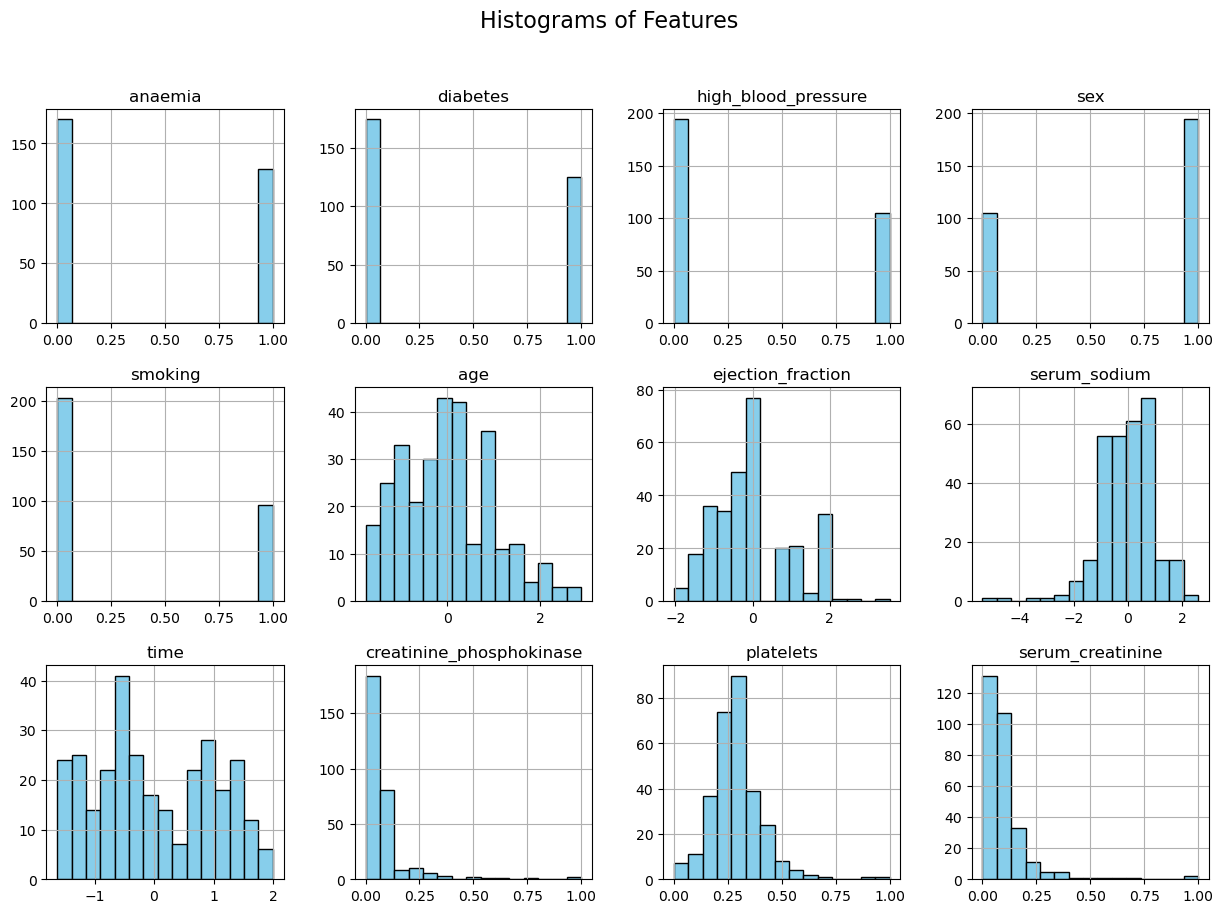

In [54]:
processed_data.iloc[:, :-1].hist(bins=15, figsize=(15, 10), layout=(3, 4), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Features', fontsize=16)
plt.show()




#print(target.head())
#print(features.head())

In [55]:
features = processed_data.iloc[:,:-1]
target = processed_data.iloc[:,12]
#print(features.head())
#print(target.head())

In [56]:
# check for imbalances
target_counts = pd.Series(target).value_counts()
print(target_counts)

0    203
1     96
Name: DEATH_EVENT, dtype: int64


In [57]:
features.describe()

,anaemia,diabetes,high_blood_pressure,sex,smoking,age,ejection_fraction,serum_sodium,time,creatinine_phosphokinase,platelets,serum_creatinine
count,299.000000,299.000000,299.000000,299.000000,299.00000,2.990000e+02,2.990000e+02,2.990000e+02,2.990000e+02,299.000000,299.000000,299.000000
mean,0.431438,0.418060,0.351171,0.648829,0.32107,5.703353e-16,-3.267546e-17,-8.673849e-16,-1.901118e-16,0.071299,0.288833,0.100436
std,0.496107,0.494067,0.478136,0.478136,0.46767,1.001676e+00,1.001676e+00,1.001676e+00,1.001676e+00,0.123793,0.118565,0.116237
min,0.000000,0.000000,0.000000,0.000000,0.00000,-1.754448e+00,-2.038387e+00,-5.363206e+00,-1.629502e+00,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,-8.281242e-01,-6.841802e-01,-5.959961e-01,-7.389995e-01,0.011929,0.227179,0.044944
50%,0.000000,0.000000,0.000000,1.000000,0.00000,-7.022315e-02,-7.076750e-03,8.503384e-02,-1.969543e-01,0.028961,0.287186,0.067416
75%,1.000000,1.000000,1.000000,1.000000,1.00000,7.718891e-01,5.853888e-01,7.660638e-01,9.387595e-01,0.071319,0.337495,0.101124
max,1.000000,1.000000,1.000000,1.000000,1.00000,2.877170e+00,3.547716e+00,2.582144e+00,1.997038e+00,1.000000,1.000000,1.000000


In [58]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=4)

features_re, target_re = smote.fit_resample(features,target)

In [59]:
# check for imbalances
target_counts = pd.Series(target_re).value_counts()
print(target_counts)

1    203
0    203
Name: DEATH_EVENT, dtype: int64


In [60]:
features_re.describe()

,anaemia,diabetes,high_blood_pressure,sex,smoking,age,ejection_fraction,serum_sodium,time,creatinine_phosphokinase,platelets,serum_creatinine
count,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000
mean,0.396552,0.381773,0.332512,0.623153,0.285714,0.084110,-0.111512,-0.047144,-0.205336,0.075691,0.284536,0.113752
std,0.489785,0.486421,0.471695,0.485194,0.452311,1.012207,1.006150,1.011068,1.000424,0.129870,0.110334,0.127031
min,0.000000,0.000000,0.000000,0.000000,0.000000,-1.754448,-2.038387,-5.363206,-1.629502,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,-0.738433,-0.910013,-0.595996,-1.122948,0.012987,0.224148,0.056180
50%,0.000000,0.000000,0.000000,1.000000,0.000000,-0.070223,-0.260991,0.079341,-0.438469,0.032258,0.284591,0.078434
75%,1.000000,1.000000,1.000000,1.000000,1.000000,0.771889,0.162199,0.539054,0.729040,0.071319,0.335374,0.131884
max,1.000000,1.000000,1.000000,1.000000,1.000000,2.877170,3.547716,2.582144,1.997038,1.000000,1.000000,1.000000


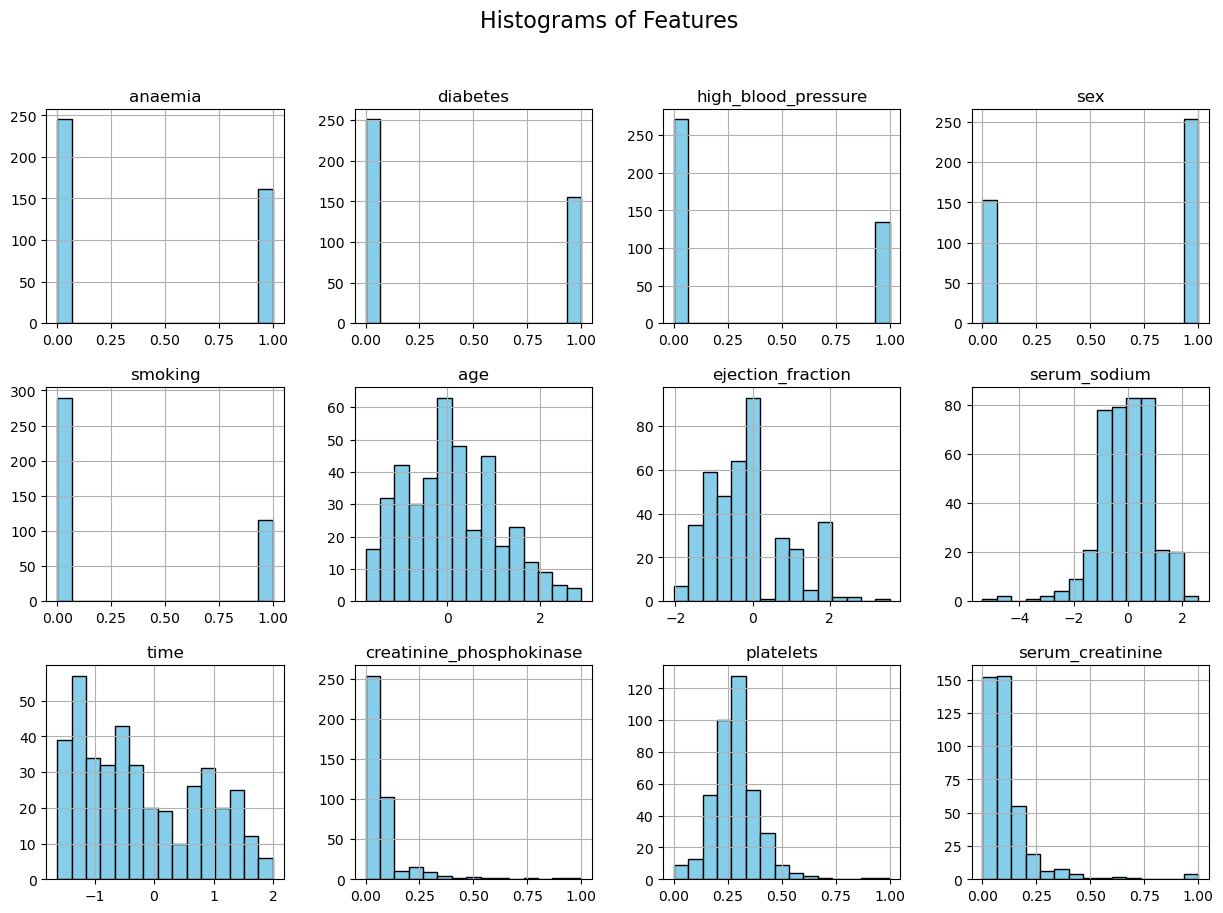

In [61]:
features_re.hist(bins=15, figsize=(15, 10), layout=(3, 4), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Features', fontsize=16)
plt.show()


In [62]:
#train/test
x1_train, x1_test, y1_train, y1_test = train_test_split(features_re, target_re, test_size=0.2, random_state=42)
x2_train, x2_test, y2_train, y2_test = train_test_split(features_re, target_re, test_size=0.5, random_state=42)
x3_train, x3_test, y3_train, y3_test = train_test_split(features_re, target_re, test_size=0.8, random_state=42)

In [63]:
#looks accurate

In [64]:
# check out the splits

print(x1_test.shape)
print(x1_train.shape)

print(x2_test.shape)
print(x2_train.shape)

print(x3_test.shape)
print(x3_train.shape)


(82, 12)
(324, 12)
(203, 12)
(203, 12)
(325, 12)
(81, 12)


In [65]:
print(x1_train)

     anaemia  diabetes  high_blood_pressure  sex  smoking       age  \
395        0         0                    0    1        0 -1.333392   
3          1         0                    0    1        0 -0.912335   
18         1         0                    1    0        0  0.771889   
131        1         1                    0    1        0 -0.070223   
118        1         1                    1    0        0  0.350833   
..       ...       ...                  ...  ...      ...       ...   
71         0         1                    0    1        1 -0.238646   
106        0         0                    0    1        0 -0.491279   
270        0         1                    1    1        1 -1.417603   
348        1         0                    0    1        0 -0.080811   
102        0         0                    0    1        1  1.614001   

     ejection_fraction  serum_sodium      time  creatinine_phosphokinase  \
395          -1.056766      0.484764 -0.982394                  0.87717

In [66]:
print("Unique values in target:", np.unique(target))
le = LabelEncoder()
target = le.fit_transform(target)

Unique values in target: [0 1]


# Naive Bayes w/ hfcr

In [67]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics


In [68]:
gnb1 = GaussianNB()
gnb2 = GaussianNB()
gnb3 = GaussianNB()

gnb1.fit(x1_train, y1_train)
gnb2.fit(x2_train, y2_train)
gnb3.fit(x3_train, y3_train)

GaussianNB()

In [69]:
pred1 = gnb1.predict(x1_test)
pred2 = gnb2.predict(x2_test)
pred3 = gnb3.predict(x3_test)

In [70]:
print("Gaussian Naive Bayes 1st model accuracy(in %):", 
      metrics.accuracy_score(y1_test, pred1)*100)

print("Gaussian Naive Bayes 2nd model accuracy(in %):", 
      metrics.accuracy_score(y2_test, pred2)*100)

print("Gaussian Naive Bayes 3rd model accuracy(in %):", 
      metrics.accuracy_score(y3_test, pred3)*100)

Gaussian Naive Bayes 1st model accuracy(in %): 84.14634146341463
Gaussian Naive Bayes 2nd model accuracy(in %): 76.35467980295566
Gaussian Naive Bayes 3rd model accuracy(in %): 68.61538461538461


In [71]:
f1_1 = f1_score(y1_test, pred1, average='weighted')
print(" 1st F1 Score:", f1_1)

f1_2 = f1_score(y2_test, pred2, average='weighted')
print(" 1st F1 Score:", f1_2)

f1_3 = f1_score(y3_test, pred3, average='weighted')
print(" 1st F1 Score:", f1_3)

 1st F1 Score: 0.8414398334077049
 1st F1 Score: 0.7604672567191307
 1st F1 Score: 0.6787368120392023


In [72]:
tot_acc_nb = (61.666666 + 68.000000 + 65.833333)/3
print(tot_acc_nb)

65.16666633333334


In [73]:
auc_roc = roc_auc_score(pred1, y1_test)
print(auc_roc)

0.8416666666666667


# Logistic Regression

In [74]:
from sklearn.linear_model import LogisticRegression

In [75]:
clf1 = LogisticRegression(max_iter=1000)

clf1.fit(x1_train,y1_train)

pred1 = clf1.predict(x1_test)

accuracy1 = metrics.accuracy_score(y1_test, pred1)
print("Accuracy:", accuracy1)


Accuracy: 0.8658536585365854


In [76]:
clf2 = LogisticRegression(max_iter=1000)

clf2.fit(x2_train,y2_train)

pred2 = clf2.predict(x2_test)

accuracy2 = metrics.accuracy_score(y2_test, pred2)
print("Accuracy:", accuracy2)

Accuracy: 0.7881773399014779


In [77]:
clf3 = LogisticRegression(max_iter=1000)

clf3.fit(x3_train,y3_train)

pred3 = clf3.predict(x3_test)

accuracy3 = metrics.accuracy_score(y3_test, pred3)
print("Accuracy:", accuracy3)

Accuracy: 0.7353846153846154


In [78]:
tot_acc_lr = (accuracy1 + accuracy2 + accuracy3)/3
print(tot_acc_lr)

0.7964718712742261


In [79]:
auc_roc = roc_auc_score(pred1, y1_test)
print(auc_roc)

0.867822966507177


# KNN

In [80]:
from sklearn.neighbors import KNeighborsClassifier

In [81]:
knn1 = KNeighborsClassifier()

knn1.fit(x1_train,y1_train)

pred1 = knn1.predict(x1_test)

accuracy1 = accuracy_score(y1_test, pred1)
print("Accuracy 1:", accuracy1)

Accuracy 1: 0.8048780487804879


In [82]:
knn2 = KNeighborsClassifier()

knn2.fit(x2_train,y2_train)

pred2 = knn2.predict(x2_test)

accuracy2 = accuracy_score(y2_test, pred2)
print("Accuracy 2:", accuracy2)

Accuracy 2: 0.7980295566502463


In [83]:
knn3 = KNeighborsClassifier()

knn3.fit(x3_train,y3_train)

pred3 = knn3.predict(x3_test)

accuracy3 = accuracy_score(y3_test, pred3)
print("Accuracy 3:", accuracy3)

Accuracy 3: 0.7846153846153846


In [84]:
tot_acc_knn = (accuracy1 + accuracy2 + accuracy3)/3
print(tot_acc_knn)

0.7958409966820396


In [85]:
auc_roc = roc_auc_score(pred1, y1_test)
print(auc_roc)

0.8078078078078078


# DATASET #2

In [89]:
pd_hrt = pd.read_csv('heart.dat', delim_whitespace=True, header=None)
print(pd_hrt)

       0    1    2      3      4    5    6      7    8    9    10   11   12  \
0    70.0  1.0  4.0  130.0  322.0  0.0  2.0  109.0  0.0  2.4  2.0  3.0  3.0   
1    67.0  0.0  3.0  115.0  564.0  0.0  2.0  160.0  0.0  1.6  2.0  0.0  7.0   
2    57.0  1.0  2.0  124.0  261.0  0.0  0.0  141.0  0.0  0.3  1.0  0.0  7.0   
3    64.0  1.0  4.0  128.0  263.0  0.0  0.0  105.0  1.0  0.2  2.0  1.0  7.0   
4    74.0  0.0  2.0  120.0  269.0  0.0  2.0  121.0  1.0  0.2  1.0  1.0  3.0   
..    ...  ...  ...    ...    ...  ...  ...    ...  ...  ...  ...  ...  ...   
265  52.0  1.0  3.0  172.0  199.0  1.0  0.0  162.0  0.0  0.5  1.0  0.0  7.0   
266  44.0  1.0  2.0  120.0  263.0  0.0  0.0  173.0  0.0  0.0  1.0  0.0  7.0   
267  56.0  0.0  2.0  140.0  294.0  0.0  2.0  153.0  0.0  1.3  2.0  0.0  3.0   
268  57.0  1.0  4.0  140.0  192.0  0.0  0.0  148.0  0.0  0.4  2.0  0.0  6.0   
269  67.0  1.0  4.0  160.0  286.0  0.0  2.0  108.0  1.0  1.5  2.0  3.0  3.0   

     13  
0     2  
1     1  
2     2  
3     1  
4

In [91]:
pd_hrt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       270 non-null    float64
 1   1       270 non-null    float64
 2   2       270 non-null    float64
 3   3       270 non-null    float64
 4   4       270 non-null    float64
 5   5       270 non-null    float64
 6   6       270 non-null    float64
 7   7       270 non-null    float64
 8   8       270 non-null    float64
 9   9       270 non-null    float64
 10  10      270 non-null    float64
 11  11      270 non-null    float64
 12  12      270 non-null    float64
 13  13      270 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 29.7 KB


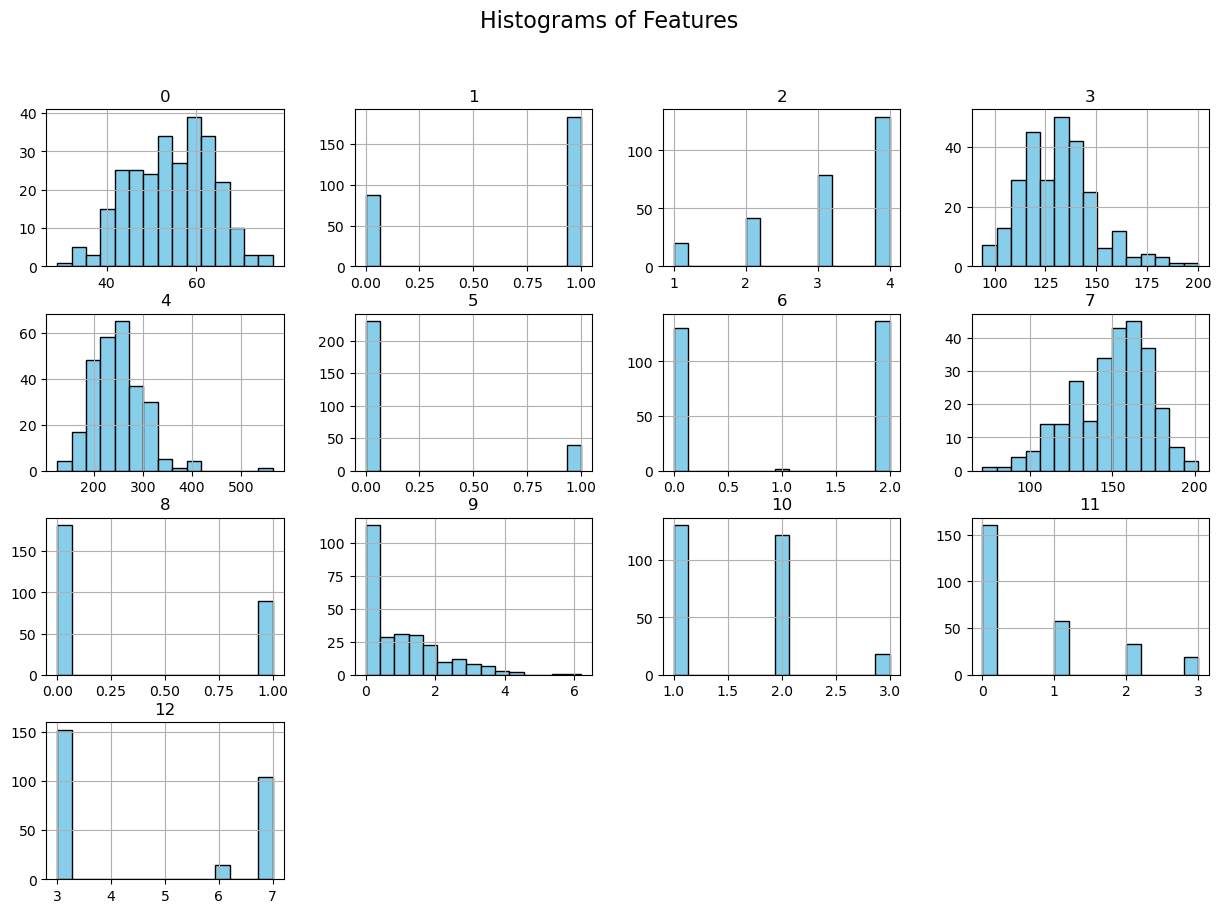

In [93]:
pd_hrt.iloc[:, :-1].hist(bins=15, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Features', fontsize=16)
plt.show()


In [96]:
binary_features = [1, 5, 8]
continuous_features_standardize = [0, 3, 4, 6, 7, 10, 12]
continuous_features_normalize = [2, 9, 11]

standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

binary_data = pd_hrt[binary_features]

# Standardize normally distributed features
standardized_data = pd.DataFrame(
    standard_scaler.fit_transform(pd_hrt[continuous_features_standardize]),
    columns=continuous_features_standardize,
)

# Normalize skewed features
normalized_data = pd.DataFrame(
    minmax_scaler.fit_transform(pd_hrt[continuous_features_normalize]),
    columns=continuous_features_normalize,
)

target = pd_hrt.iloc[:, -1]

# 4. Combine all features back into a single dataset
processed_data = pd.concat([binary_data, standardized_data, normalized_data, target], axis=1)

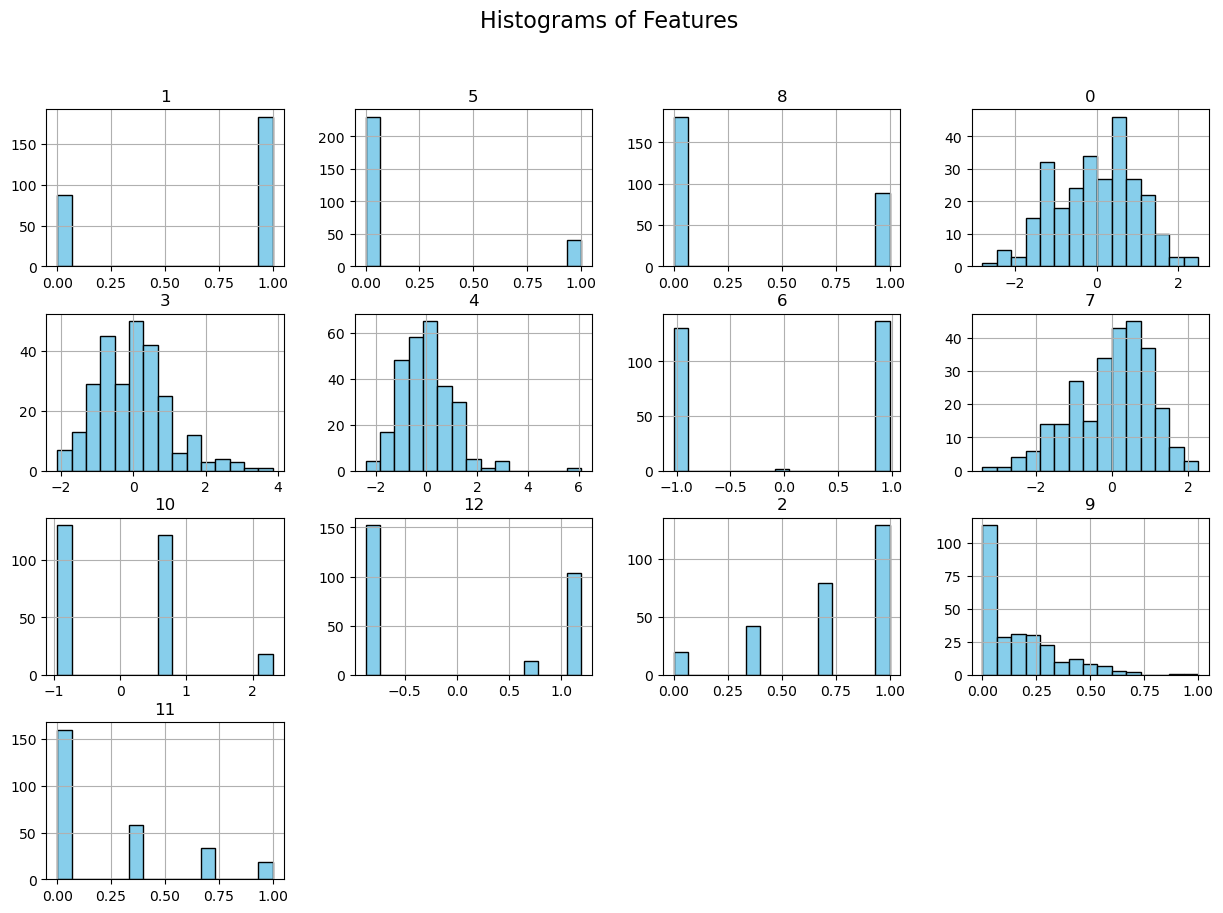

In [97]:
processed_data.iloc[:, :-1].hist(bins=15, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Features', fontsize=16)
plt.show()


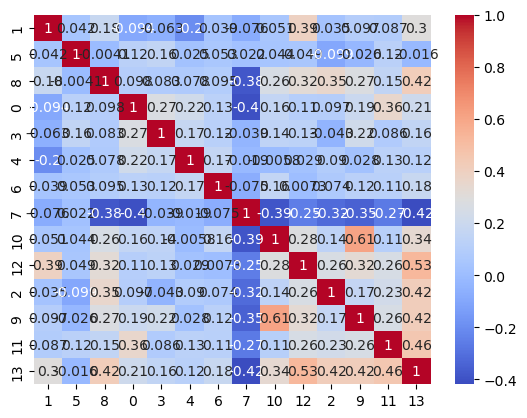

In [104]:
corr_matrix = processed_data.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [98]:
target_counts = pd.Series(target).value_counts()
print(target_counts)

1    150
2    120
Name: 13, dtype: int64


In [99]:
features = processed_data.iloc[:, :-1]
target = processed_data.iloc[:, -1]

In [100]:
x1_train, x1_test, y1_train, y1_test = train_test_split(features, target, test_size=0.2, random_state=42)
x2_train, x2_test, y2_train, y2_test = train_test_split(features, target, test_size=0.5, random_state=42)
x3_train, x3_test, y3_train, y3_test = train_test_split(features, target, test_size=0.8, random_state=42)

# Naive Bayes

In [101]:
gnb1 = GaussianNB()
gnb2 = GaussianNB()
gnb3 = GaussianNB()

gnb1.fit(x1_train, y1_train)
gnb2.fit(x2_train, y2_train)
gnb3.fit(x3_train, y3_train)

GaussianNB()

In [102]:
pred1 = gnb1.predict(x1_test)
pred2 = gnb2.predict(x2_test)
pred3 = gnb3.predict(x3_test)

In [103]:
print("Gaussian Naive Bayes 1st model accuracy(in %):", 
      metrics.accuracy_score(y1_test, pred1)*100)

print("Gaussian Naive Bayes 2nd model accuracy(in %):", 
      metrics.accuracy_score(y2_test, pred2)*100)

print("Gaussian Naive Bayes 3rd model accuracy(in %):", 
      metrics.accuracy_score(y3_test, pred3)*100)

Gaussian Naive Bayes 1st model accuracy(in %): 90.74074074074075
Gaussian Naive Bayes 2nd model accuracy(in %): 83.7037037037037
Gaussian Naive Bayes 3rd model accuracy(in %): 81.48148148148148


In [105]:
auc_roc = roc_auc_score(pred1, y1_test)
print(auc_roc)

0.9166666666666666


# Logistic Regression

In [106]:
clf1 = LogisticRegression(max_iter=1000)

clf1.fit(x1_train,y1_train)

pred1 = clf1.predict(x1_test)

accuracy1 = metrics.accuracy_score(y1_test, pred1)
print("Accuracy:", accuracy1)


Accuracy: 0.9074074074074074


In [107]:
clf2 = LogisticRegression(max_iter=1000)

clf2.fit(x2_train,y2_train)

pred2 = clf2.predict(x2_test)

accuracy2 = metrics.accuracy_score(y2_test, pred2)
print("Accuracy:", accuracy2)

Accuracy: 0.7851851851851852


In [108]:
clf3 = LogisticRegression(max_iter=1000)

clf3.fit(x3_train,y3_train)

pred3 = clf3.predict(x3_test)

accuracy3 = metrics.accuracy_score(y3_test, pred3)
print("Accuracy:", accuracy3)

Accuracy: 0.7731481481481481


# KNN

In [109]:
knn1 = KNeighborsClassifier()

knn1.fit(x1_train,y1_train)

pred1 = knn1.predict(x1_test)

accuracy1 = accuracy_score(y1_test, pred1)
print("Accuracy 1:", accuracy1)

Accuracy 1: 0.8148148148148148


In [110]:
knn2 = KNeighborsClassifier()

knn2.fit(x2_train,y2_train)

pred2 = knn2.predict(x2_test)

accuracy2 = accuracy_score(y2_test, pred2)
print("Accuracy 2:", accuracy2)

Accuracy 2: 0.762962962962963


In [ ]:
knn3 = KNeighborsClassifier()

knn3.fit(x3_train,y3_train)  

pred3 = knn3.predict(x3_test)

accuracy3 = accuracy_score(y3_test, pred3)
print("Accuracy 3:", accuracy3)

Accuracy 3: 0.7361111111111112


# Dataset 3

In [ ]:
spectf = pd.read_csv('SPECTF.train', header= None)

print(spectf.head())
print(spectf.shape)

In [ ]:
spectf_test = pd.read_csv('SPECTF.test', header= None)

print(spectf_test.head())
print(spectf_test.shape)

(187, 45)
